In [1]:
%pylab inline
from sympy import init_printing
init_printing(use_latex='mathjax')
import os
os.chdir(os.path.join(os.curdir,'data'))

Populating the interactive namespace from numpy and matplotlib


# 3.1 单应性变换(Homography)
---

https://zh.wikipedia.org/wiki/%E5%8D%95%E5%BA%94%E6%80%A7

https://en.wikipedia.org/wiki/Homography_(computer_vision)

$$
\begin{bmatrix}
x'\\ 
y'\\ 
w'
\end{bmatrix}
=
\begin{bmatrix}
h_1 & h_2 & h_3\\ 
h_4 & h_5 & h_6\\ 
h_7 & h_8 & h_9
\end{bmatrix}
\begin{bmatrix}
x \\ 
y \\ 
z
\end{bmatrix}
$$

或

$$
\mathrm{x' = Hx}
$$

## 3.1.1 直接线性变换算法(DLT)
https://en.wikipedia.org/wiki/Direct_linear_transformation

给定4个以上对应点来计算H:

$$
\begin{bmatrix}
-x_1 & -y_1  & -1 & 0 & 0 & 0 & x_1x_1' & y_1x_1' & x_1'\\ 
0 & 0  & 0 & -x_1 & -y_1  & -1& x_1y_1' & y_1y_1' & y_1'\\ 
-x_2 & -y_2  & -1 & 0 & 0 & 0 & x_2x_2' & y_2x_2' & x_2'\\ 
0 & 0  & 0 & -x_2 & -y_2  & -2& x_2y_2' & y_2y_2' & y_2'\\ 
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots
\end{bmatrix}
\begin{bmatrix}
h_1 \\ 
h_2 \\
h_3 \\
h_4 \\
h_5 \\
h_6 \\
h_7 \\ 
h_8 \\
h_9 
\end{bmatrix}
=0
$$

或者 $\mathrm{Ah = 0}$ ,其中 $A$ 是一个具有对应点对二倍数量行数的矩阵.将对应点对方程的系数堆叠到一个矩阵中,就可以使用 SVD算法找到H的最小二乘解.

In [2]:
def H_from_points(fp,tp):
    """ 使用DLT方法,计算单应性矩阵H,使得fp映射到tp,点自动归一化"""
    
    if fp.shape != tp.shape:
        raise RuntimeError('number of points do not match')
        
    # 对点进行归一化(对数值计算很重要)
    # --映射起始点--
    m = mean(fp[:2], axis=1)
    maxstd = max(std(fp[:2], axis=1)) + 1e-9
    C1 = diag([1/maxstd, 1/maxstd, 1]) 
    C1[0][2] = -m[0]/maxstd
    C1[1][2] = -m[1]/maxstd
    fp = dot(C1,fp)
    
    # --映射对应点--
    m = mean(tp[:2], axis=1)
    maxstd = max(std(tp[:2], axis=1)) + 1e-9
    C2 = diag([1/maxstd, 1/maxstd, 1])
    C2[0][2] = -m[0]/maxstd
    C2[1][2] = -m[1]/maxstd
    tp = dot(C2,tp)
    
    # 创建用于线性方法的矩阵,对于每个对应对,在矩阵中都会出现两行数值
    nbr_correspondences = fp.shape[1]
    A = zeros((2*nbr_correspondences,9))
    for i in range(nbr_correspondences):        
        A[2*i] = [-fp[0][i],-fp[1][i],-1,0,0,0,
                    tp[0][i]*fp[0][i],tp[0][i]*fp[1][i],tp[0][i]]
        A[2*i+1] = [0,0,0,-fp[0][i],-fp[1][i],-1,
                    tp[1][i]*fp[0][i],tp[1][i]*fp[1][i],tp[1][i]]
    
    U,S,V = linalg.svd(A)
    H = V[8].reshape((3,3)) # 最小二乘解  ?
    
    # decondition 反归一化
    H = dot(linalg.inv(C2),dot(H,C1))
    
    # 归一化,然后返回
    return H / H[2,2]

## 3.1.2 仿射变换

In [3]:
def Haffine_from_points(fp,tp):
    """ 计算H, 放射变换 affine transformation, 
        tp 是由 fp 经放射变换 H 得到的. """
    
    if fp.shape != tp.shape:
        raise RuntimeError('number of points do not match')
        
    # condition points 归一化
    # --from points-- 起始点
    m = mean(fp[:2], axis=1)
    maxstd = max(std(fp[:2], axis=1)) + 1e-9
    C1 = diag([1/maxstd, 1/maxstd, 1]) 
    C1[0][2] = -m[0]/maxstd
    C1[1][2] = -m[1]/maxstd
    fp_cond = dot(C1,fp)
    
    # --to points-- 对应点
    m = mean(tp[:2], axis=1)
    C2 = C1.copy() #must use same scaling for both point sets 两个点集必须进行相同的缩放
    C2[0][2] = -m[0]/maxstd
    C2[1][2] = -m[1]/maxstd
    tp_cond = dot(C2,tp)
    
    # conditioned points have mean zero, so translation is zero
    A = concatenate((fp_cond[:2],tp_cond[:2]), axis=0)
    U,S,V = linalg.svd(A.T)
    
    # create B and C matrices as Hartley-Zisserman (2:nd ed) p 130.
    tmp = V[:2].T
    B = tmp[:2]
    C = tmp[2:4]
    
    tmp2 = concatenate((dot(C,linalg.pinv(B)),zeros((2,1))), axis=1) 
    H = vstack((tmp2,[0,0,1]))
    
    # decondition
    H = dot(linalg.inv(C2),dot(H,C1))
    
    return H / H[2,2]

### OpenCV版 图像重映射 remap

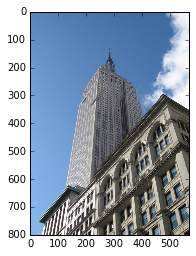

In [4]:
import cv2
# 1.读取图像
srcImage = cv2.imread('empire.jpg')
srcImage = cv2.cvtColor(srcImage,cv2.COLOR_BGR2RGB)  # 转为RGB用于matplot显示
src_rows, src_cols,depth = srcImage.shape
imshow(srcImage)

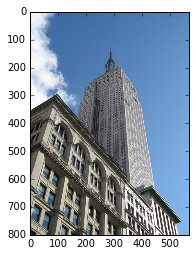

In [5]:
# 2.创建和原始图一样的效果图，x重映射图，y重映射图
dstImage = srcImage.copy()
map_x = np.zeros((src_rows,src_cols),np.float32)
map_y = np.zeros((src_rows,src_cols),np.float32)

# 3.双层循环，遍历每一个像素点，改变map_x & map_y的值
for j in xrange(src_rows):
    for i in xrange(src_cols):
        map_x[j,i] = src_cols - i
        map_y[j,i] = j
        
# 4.进行重映射操作
dstImage = cv2.remap(srcImage, map_x, map_y, cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(0,0,0) );
imshow(dstImage)

### Opencv 计算变换矩阵
---
计算函数:
```python
cv2.resize(src, dsize[, dst[, fx[, fy[, interpolation ]]]]) -> dst  # 改变图像大小
# fx = dsize.width/src.cols 
# fy = dsize.height/src.rows
# interpolation 插值方法
#   – INTER_NEAREST - a nearest-neighbor interpolation 最邻近点插值
#   – INTER_LINEAR - a bilinear interpolation (used by default) 双线性插值
#   – INTER_AREA - resampling using pixel area relation. It may be a preferred method for
#     image decimation, as it gives moire’-free results. But when the image is zoomed, it is
#     similar to the INTER_NEAREST method.
#   – INTER_CUBIC - a bicubic interpolation over 4x4 pixel neighborhood 双三次插值
#   – INTER_LANCZOS4 - a Lanczos interpolation over 8x8 pixel neighborhood 

cv2.estimateRigidTransform(src, dst, fullAffine) -> retval # 获得刚体变换(旋转平移变换,最小二乘)src,dst 为点序列,输出为 2x3 的变换矩阵
cv2.getAffineTransform(src, dst) -> retval  # 获得仿射变换,src,dst 为三对点序列,输出为2x3 的变换矩阵
cv2.warpAffine(src, M, dsize[, dst[, flags[, borderMode[, borderValue ]]]]) -> dst  # 应用仿射变换
cv2.getPerspectiveTransform(src, dst) -> retval # 获得透视变换,src,dst 为四对点序列,输出为3x3 的变换矩阵
cv2.warpPerspective(src, M, dsize[, dst[, flags[, borderMode[, borderValue ]]]]) -> dst # 应用透视变换

cv2.findFundamentalMat(points1, points2[, method[, param1[, param2[, mask ]]]]) -> retval,mask
# 求得基础单应性矩阵 points1为图像1上的点,points2为图像2上的对应点
# method
#   – CV_FM_7POINT for a 7-point algorithm. N = 7
#   – CV_FM_8POINT for an 8-point algorithm. N ≥ 8
#   – CV_FM_RANSAC for the RANSAC algorithm. N ≥ 8
#   – CV_FM_LMEDS for the LMedS algorithm. N ≥ 8
# param1 – Parameter used for RANSAC. It is the maximum distance from a point to an
#   epipolar line in pixels, beyond which the point is considered an outlier and is not used for
#   computing the final fundamental matrix. It can be set to something like 1-3, depending on
#   the accuracy of the point localization, image resolution, and the image noise.
# param2 – Parameter used for the RANSAC or LMedS methods only. It specifies a desirable
#   level of confidence (probability) that the estimated matrix is correct.
# status – Output array of N elements, every element of which is set to 0 for outliers and to 1
#   for the other points. The array is computed only in the RANSAC and LMedS methods. For
#   other methods, it is set to all 1’s.

cv2.findHomography(srcPoints, dstPoints[, method[, ransacReprojThreshold[, mask ]]]) -> retval, mask
# 求得单应性矩阵,srcPoints 为起始平面上的点序列, dstPoints为目标平面上的点序列
# method 求解方法
#  – 0 - a regular method using all the points 使用所有点的常规方法
#  – CV_RANSAC - RANSAC-based robust method RANSAC(RANdom Sample Consensus) 随机一次性采样
#  – CV_LMEDS - Least-Median robust method  最小二乘法
# ransacReprojThreshold – Maximum allowed reprojection error to treat a point pair as an
#    inlier (used in the RANSAC method only).

cv2.estimateAffine3D(src, dst[, out[, inliers[, ransacThreshold[, confidence ]]]]) -> retval, out, inliers # 三维仿射变换估算
```

# 3.2 图像扭曲

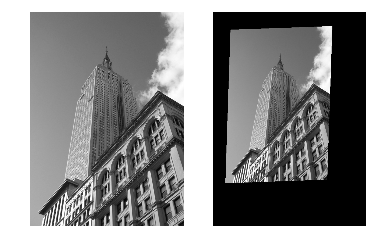

In [6]:
from PIL import Image
from scipy import ndimage

im = array(Image.open('empire.jpg').convert('L'))
H = array([[1.4,0.05,-100],[0.05,1.5,-100],[0,0,1]])
im2 = ndimage.affine_transform(im,H[:2,:2],(H[0,2],H[1,2]))

figure()
gray()
subplot(121)
axis('off')
imshow(im)
subplot(122)
axis('off')
imshow(im2)
show()

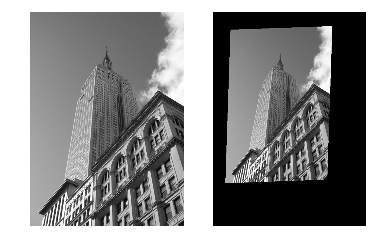

In [7]:
srcImage = cv2.imread('empire.jpg',0)
H = array([[1.4,0.05,-100],[0.05,1.5,-100]])
size = srcImage.shape
dstImage = cv2.warpAffine(srcImage,H,size)

figure()
gray()
subplot(121)
axis('off')
imshow(srcImage)
subplot(122)
axis('off')
imshow(im2)
show()

In [8]:
def image_in_image(im1,im2,tp):
    """ 使用放射变换将 im1 放到 im2 上
        使得im1图像四角点尽可能和 tp 靠近such that corners are as close to tp as possible.
        tp are homogeneous and counter-clockwise from top left. 
        """ 
    # 映射的点
    m,n = im1.shape[:2]
    fp = np.float32([[0,0],[m,0],[m,n],[0,n]])
    
    # 计算仿射变换并应用
    H = cv2.getPerspectiveTransform(fp, tp)
    if len(im2.shape) == 2:
        rows,cols = im2.shape
    elif len(im2.shape) == 3:
        rows,cols,ch = im2.shape
    im1_t = cv2.warpPerspective(im1,H,(cols,rows))
    alpha = (im1_t > 0)
    
    return (1-alpha)*im2 + alpha*im1_t

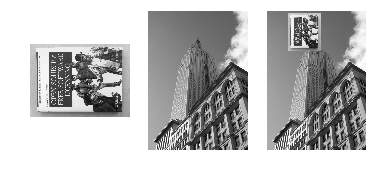

In [9]:
im1 = array(Image.open('book_frontal.jpg').convert('L'))
im2 = array(Image.open('empire.jpg').convert('L'))
# set to points
tp = np.float32([[120,16],[260,16],[260,305],[120,305]])
im3 = image_in_image(im1,im2,tp)
figure()
gray()
subplot(131)
axis('off')
imshow(im1)
subplot(132)
axis('off')
imshow(im2)
subplot(133)
axis('off')
imshow(im3)

## 3.2.2 分段仿射扭曲
---
仿射变换需要三对点,因此将图像分割成三角形即可使用仿射变换,将图像分成许多三角形即为仿射扭曲.

将点三角化最常用的是帝洛克三角剖分 (Delaunay) http://matplotlib.org/api/tri_api.html

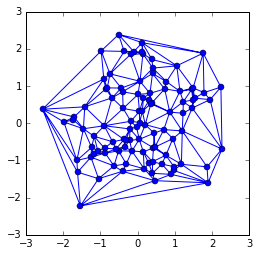

In [10]:
from matplotlib import tri

np.random.seed(0) # 将随机数种子复位,保证生成固定的随机序列
x,y = array(random.standard_normal((2,100)))

# Create the Triangulation; no triangles so Delaunay triangulation created.
triang = tri.Triangulation(x, y)

# Plot the triangulation.
plt.figure()
plt.gca().set_aspect('equal')
plt.triplot(triang, 'bo-')  # 绘制三角形对象

In [11]:
triang.triangles[0]  # 三角形,其内容为点的序号

array([44,  5, 61])

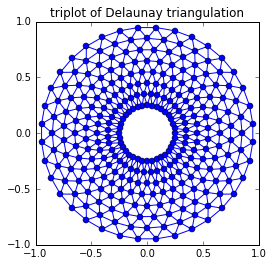

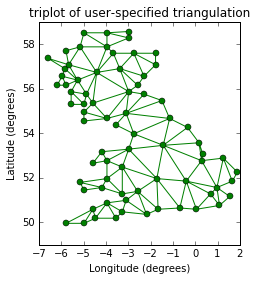

In [12]:
"""
Creating and plotting unstructured triangular grids.
"""
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np
import math

# Creating a Triangulation without specifying the triangles results in the
# Delaunay triangulation of the points.

# First create the x and y coordinates of the points.
n_angles = 36
n_radii = 8
min_radius = 0.25
radii = np.linspace(min_radius, 0.95, n_radii)

angles = np.linspace(0, 2*math.pi, n_angles, endpoint=False)
angles = np.repeat(angles[..., np.newaxis], n_radii, axis=1)
angles[:, 1::2] += math.pi/n_angles

x = (radii*np.cos(angles)).flatten()
y = (radii*np.sin(angles)).flatten()

# Create the Triangulation; no triangles so Delaunay triangulation created.
triang = tri.Triangulation(x, y)

# Mask off unwanted triangles.
xmid = x[triang.triangles].mean(axis=1)
ymid = y[triang.triangles].mean(axis=1)
mask = np.where(xmid*xmid + ymid*ymid < min_radius*min_radius, 1, 0)
triang.set_mask(mask)

# Plot the triangulation.
plt.figure()
plt.gca().set_aspect('equal')
plt.triplot(triang, 'bo-')
plt.title('triplot of Delaunay triangulation')


# You can specify your own triangulation rather than perform a Delaunay
# triangulation of the points, where each triangle is given by the indices of
# the three points that make up the triangle, ordered in either a clockwise or
# anticlockwise manner.

xy = np.asarray([
    [-0.101, 0.872], [-0.080, 0.883], [-0.069, 0.888], [-0.054, 0.890],
    [-0.045, 0.897], [-0.057, 0.895], [-0.073, 0.900], [-0.087, 0.898],
    [-0.090, 0.904], [-0.069, 0.907], [-0.069, 0.921], [-0.080, 0.919],
    [-0.073, 0.928], [-0.052, 0.930], [-0.048, 0.942], [-0.062, 0.949],
    [-0.054, 0.958], [-0.069, 0.954], [-0.087, 0.952], [-0.087, 0.959],
    [-0.080, 0.966], [-0.085, 0.973], [-0.087, 0.965], [-0.097, 0.965],
    [-0.097, 0.975], [-0.092, 0.984], [-0.101, 0.980], [-0.108, 0.980],
    [-0.104, 0.987], [-0.102, 0.993], [-0.115, 1.001], [-0.099, 0.996],
    [-0.101, 1.007], [-0.090, 1.010], [-0.087, 1.021], [-0.069, 1.021],
    [-0.052, 1.022], [-0.052, 1.017], [-0.069, 1.010], [-0.064, 1.005],
    [-0.048, 1.005], [-0.031, 1.005], [-0.031, 0.996], [-0.040, 0.987],
    [-0.045, 0.980], [-0.052, 0.975], [-0.040, 0.973], [-0.026, 0.968],
    [-0.020, 0.954], [-0.006, 0.947], [ 0.003, 0.935], [ 0.006, 0.926],
    [ 0.005, 0.921], [ 0.022, 0.923], [ 0.033, 0.912], [ 0.029, 0.905],
    [ 0.017, 0.900], [ 0.012, 0.895], [ 0.027, 0.893], [ 0.019, 0.886],
    [ 0.001, 0.883], [-0.012, 0.884], [-0.029, 0.883], [-0.038, 0.879],
    [-0.057, 0.881], [-0.062, 0.876], [-0.078, 0.876], [-0.087, 0.872],
    [-0.030, 0.907], [-0.007, 0.905], [-0.057, 0.916], [-0.025, 0.933],
    [-0.077, 0.990], [-0.059, 0.993]])
x = np.degrees(xy[:, 0])
y = np.degrees(xy[:, 1])

triangles = np.asarray([
    [67, 66,  1], [65,  2, 66], [ 1, 66,  2], [64,  2, 65], [63,  3, 64],
    [60, 59, 57], [ 2, 64,  3], [ 3, 63,  4], [ 0, 67,  1], [62,  4, 63],
    [57, 59, 56], [59, 58, 56], [61, 60, 69], [57, 69, 60], [ 4, 62, 68],
    [ 6,  5,  9], [61, 68, 62], [69, 68, 61], [ 9,  5, 70], [ 6,  8,  7],
    [ 4, 70,  5], [ 8,  6,  9], [56, 69, 57], [69, 56, 52], [70, 10,  9],
    [54, 53, 55], [56, 55, 53], [68, 70,  4], [52, 56, 53], [11, 10, 12],
    [69, 71, 68], [68, 13, 70], [10, 70, 13], [51, 50, 52], [13, 68, 71],
    [52, 71, 69], [12, 10, 13], [71, 52, 50], [71, 14, 13], [50, 49, 71],
    [49, 48, 71], [14, 16, 15], [14, 71, 48], [17, 19, 18], [17, 20, 19],
    [48, 16, 14], [48, 47, 16], [47, 46, 16], [16, 46, 45], [23, 22, 24],
    [21, 24, 22], [17, 16, 45], [20, 17, 45], [21, 25, 24], [27, 26, 28],
    [20, 72, 21], [25, 21, 72], [45, 72, 20], [25, 28, 26], [44, 73, 45],
    [72, 45, 73], [28, 25, 29], [29, 25, 31], [43, 73, 44], [73, 43, 40],
    [72, 73, 39], [72, 31, 25], [42, 40, 43], [31, 30, 29], [39, 73, 40],
    [42, 41, 40], [72, 33, 31], [32, 31, 33], [39, 38, 72], [33, 72, 38],
    [33, 38, 34], [37, 35, 38], [34, 38, 35], [35, 37, 36]])

# Rather than create a Triangulation object, can simply pass x, y and triangles
# arrays to triplot directly.  It would be better to use a Triangulation object
# if the same triangulation was to be used more than once to save duplicated
# calculations.
plt.figure()
plt.gca().set_aspect('equal')
plt.triplot(x, y, triangles, 'go-')
plt.title('triplot of user-specified triangulation')
plt.xlabel('Longitude (degrees)')
plt.ylabel('Latitude (degrees)')

plt.show()

### OpenCV 版

http://blog.csdn.net/newthinker_wei/article/details/45598769

http://stackoverflow.com/questions/16603780/delaunay-triangulation-opencv-c

In [13]:
def draw_subdiv(img, subdiv, delaunay_color=(255,0,0)):
    triangleList = subdiv.getTriangleList()
    for t in triangleList:
        t = np.array(t)
        t = np.int16(t)
        pt0 = (t[0],t[1])
        pt1 = (t[2],t[3])
        pt2 = (t[4],t[5])
        cv2.line(img,pt0,pt1,delaunay_color,3)
        cv2.line(img,pt1,pt2,delaunay_color,3)
        cv2.line(img,pt2,pt0,delaunay_color,3)
    return img

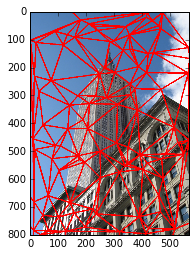

In [14]:
image = cv2.imread('empire.jpg',0)
rows,cols = image.shape
rect = (0,0,cols, rows)
subdiv = cv2.Subdiv2D(rect)
np.random.seed(0)

X = np.random.choice(np.arange(0,cols,step=1),size=(100),replace=False)
Y = np.random.choice(np.arange(0,rows,step=1),size=(100),replace=False)
for x,y in zip(X,Y):
    subdiv.insert((x,y))

rgb_im = cv2.cvtColor(cv2.imread('empire.jpg'),cv2.COLOR_BGR2RGB)
imshow(draw_subdiv(rgb_im,subdiv))

In [15]:
vertexIndex1, vertexPoint1 = subdiv.findNearest((10,2)) # 获取到点pt最近的细分顶点(vertex)
vertexPoint2, edge = subdiv.getVertex(vertexIndex1)  # 由索引获取细分顶点,egde为边(编号),起始点为该顶点vertex
assert vertexPoint1 == vertexPoint2
vertexIndex3, vertexPoint3 = subdiv.edgeOrg(edge) # 获得该边的起始点及其索引
assert vertexIndex3 == vertexIndex1
assert vertexPoint3 == vertexPoint2
vertexIndex, vertexPoint4 = subdiv.edgeDst(edge) # 获得该边的起始点及其索引

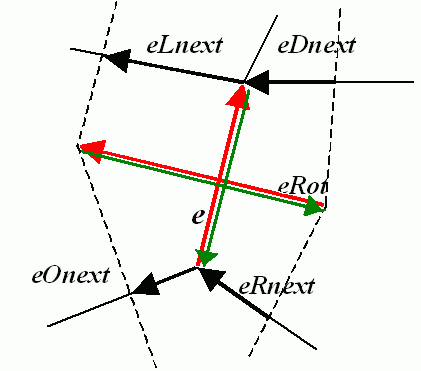

In [16]:
from PIL import Image
Image.open('Subdiv2DGetEdge.png')

In [17]:
# 上图中 e 为输入边 edge
e = edge
out_edge = subdiv.nextEdge  # eOnext
out_edge = subdiv.getEdge(e,cv2.CV_NEXT_AROUND_ORG)  # eOnext
out_edge = subdiv.getEdge(e,cv2.CV_NEXT_AROUND_DST)  # eDnext  
out_edge = subdiv.getEdge(e,cv2.CV_PREV_AROUND_ORG)  # eRnext 的反向
out_edge = subdiv.getEdge(e,cv2.CV_PREV_AROUND_DST)  # eLnext 的反向
out_edge = subdiv.getEdge(e,cv2.CV_NEXT_AROUND_LEFT)  # eLnext  
out_edge = subdiv.getEdge(e,cv2.CV_NEXT_AROUND_RIGHT)  # eRnext
out_edge = subdiv.getEdge(e,cv2.CV_PREV_AROUND_LEFT)  # eOnext 的反向
out_edge = subdiv.getEdge(e,cv2.CV_PREV_AROUND_RIGHT)  # eDnext 的反向
out_edge = subdiv.rotateEdge(e,0) # e
out_edge = subdiv.rotateEdge(e,1) # eRot
out_edge = subdiv.rotateEdge(e,2) # e 的反向
out_edge = subdiv.rotateEdge(e,3) # eRot 的反向

In [18]:
EdgeList = subdiv.getEdgeList()  # 边的序列,每行依次为一个边的顶点坐标
TriangleList = subdiv.getTriangleList()  # 三角形的序列,每行依次为一三角形的顶点坐标

In [19]:
# 未知, Returns the location of a point within a Delaunay triangulation
subdiv.locate((2,10))

(0, 192, 0)

In [20]:
subdiv.symEdge(edge)  # 未知

1098

In [21]:
# subdiv.getVoronoiFacetList() # 用于人脸识别

In [22]:
rect = (0,0,100, 200)
subdiv = cv2.Subdiv2D(rect)

In [23]:
vertexIndex = subdiv.insert((1,0))
vertexIndex = subdiv.insert((2,5))
vertexIndex = subdiv.insert((4,8))
vertexIndex = subdiv.insert((5,10))
vertexIndex = subdiv.insert((4,50))
vertexIndex = subdiv.insert((6,30))
vertexIndex = subdiv.insert((3,20))
vertexIndex = subdiv.insert((9,50))

In [24]:
subdiv.getVertex(4) # 三角剖分顶点的前4个为四个角点,之后顶点的顺序与插入的顺序相同

((1.0, 0.0), 74)

In [25]:
vertexIndex = subdiv.insert((0,199.9)) # 不能包含边界点

In [26]:
try:
    vertexIndex = subdiv.insert((0,200))
except:
    print(u"不能包含边界点")

不能包含边界点


In [27]:
try:
    vertexIndex = subdiv.insert((100,2))
except:
    print(u"不能包含边界点")

不能包含边界点


### 图3-5 演示示例

F:\Anaconda2\lib\site-packages\matplotlib\cbook.py:136: MatplotlibDeprecationWarning: The matplotlib.delaunay module was deprecated in version 1.4. Use matplotlib.tri.Triangulation instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


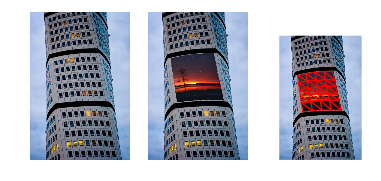

In [28]:
from pylab import *
from PIL import Image
from PCV.geometry import warp

"""
This is the piecewise affine warp example from Section 3.2, Figure 3-5.
"""

# open image to warp
fromim = array(Image.open('sunset_tree.jpg')) 
x, y = meshgrid(range(5), range(6))

x = (fromim.shape[1]/4) * x.flatten()
y = (fromim.shape[0]/5) * y.flatten()

# triangulate
tri = warp.triangulate_points(x, y)

# open image and destination points
im = array(Image.open('turningtorso1.jpg'))

figure()
subplot(1, 3, 1)
axis('off')
imshow(im)

tp = loadtxt('turningtorso1_points.txt', 'int')  # destination points

# convert points to hom. coordinates (make sure they are of type int)
fp = array(vstack((y, x, ones((1, len(x))))), 'int')
tp = array(vstack((tp[:, 1], tp[:, 0], ones((1, len(tp))))), 'int')

# warp triangles
im = warp.pw_affine(fromim, im, fp, tp, tri)

# plot
subplot(1, 3, 2)
axis('off')
imshow(im)
subplot(1, 3, 3)
axis('off')
imshow(im)
warp.plot_mesh(tp[1], tp[0], tri)

show()

#### OpenCV 版本
---
[Warp one triangle to another using OpenCV ( C++ / Python )](http://www.learnopencv.com/warp-one-triangle-to-another-using-opencv-c-python/)

In [29]:
def warpTriangle(fromim,toim,fp,tp):
    '''
    fromim = 将要扭曲的图像
    toim = 目标图像
    fp = 扭曲前的三个点
    tp = 扭曲后的三个点
    输出: 
    将要扭曲的图像上fp组成的三角形区域进行仿射变换到目标图像上tp组成的三角形区域
    '''
    assert fp.shape == (3,2) and tp.shape == (3,2)
    rows,cols = toim.shape[:2]
    im = toim.copy()
    fp = np.float32(fp)
    tp = np.float32(tp)
    H = cv2.getAffineTransform(fp,tp)
    im_t = cv2.warpAffine(fromim, H, (cols,rows))
    mask = np.zeros_like(im_t)
    cv2.fillConvexPoly(mask, np.int32(tp), (255,255,255))
    im[mask>0] = im_t[mask>0]
    return im

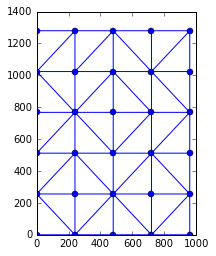

In [30]:
from matplotlib import tri

# 打开用来映射的图像
fromim = cv2.imread('sunset_tree.jpg')
fromim = cv2.cvtColor(fromim,cv2.COLOR_BGR2RGB)
x, y = meshgrid(range(5), range(6))

# 获得初始点
x = (fromim.shape[1]/4) * x.flatten()
y = (fromim.shape[0]/5) * y.flatten()
triang = tri.Triangulation(x, y)

# 显示三角网格
plt.figure()
plt.gca().set_aspect('equal')
plt.triplot(triang, 'bo-')  # 绘制三角形对象

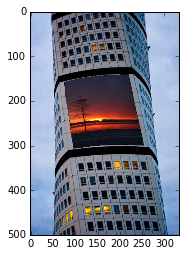

In [31]:
# 载入对应图像
im = cv2.imread('turningtorso1.jpg')
im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)

# 载入对应点
tp = loadtxt('turningtorso1_points.txt', 'int')  # destination points

fp = array(vstack((x, y)), 'int')
tp = array(vstack((tp[:, 0], tp[:, 1])), 'int')
# 只需要一次三角划分,将三个顶点的变换前和变换后的对应点带入即可
im_t = im.copy()
for t in triang.triangles:
    im_t = warpTriangle(fromim,im_t,fp[:,t].T,tp[:,t].T)
imshow(im_t)

#### 纯 OpenCV 版本
---
即实现:
```python
triang = tri.Triangulation(x, y)
triang.triangles
```
相似的功能.

问题在于 subdiv.getTriangleList 获得的是剖分点的坐标,而非序列,这可以用构造查找表来解决也可以用插值函数来解决.

In [32]:
def gen_find_index_list_func(fp):
    '''用查找表的方式获得索引'''
    fp = np.int32(fp)

    min_x = min(fp[:,0])
    max_x = max(fp[:,0])
    min_y = min(fp[:,1])
    max_y = max(fp[:,1])
    
    find_list = np.zeros((max_x - min_x + 1, max_y - min_y + 1))
    for index in range(len(fp)):
        p = fp[index,:]
        find_list[p[0]-min_x,p[1]-min_y] = index
    
    def func(fx,fy):
        fx = int(fx)
        fy = int(fy)
        ind = find_list[fx-min_x, fy-min_y]
        return ind
    
    return func

In [33]:
from scipy.interpolate import Rbf

def gen_find_index_spline_func(fp):
    '''用插值的方式'''
    fp = np.int32(fp)
    
    x = fp[:,0]
    y = fp[:,1]
    z = np.arange(len(fp))
    index_f = Rbf(x, y, z)
    
    def func(fx,fy):
        ind = int(index_f(fx, fy))
        return ind
    
    return func

同时 subdiv.getTriangleList 方法获得的剖分点并非一定在图像内,且在插入剖分点时不能插入矩形的边界点.

In [34]:
def insert_check(x,y,rect):
    min_x, min_y, max_x, max_y = rect
    eps = 0.001
    if x == min_x:
        x += eps
    if y == min_y:
        y += eps
    if x == max_x:
        x -= eps
    if y == max_y:
        y -= eps
    return x,y

In [35]:
def tri_check(tri,rect):
    min_x, min_y, max_x, max_y = rect
    
    if np.any(tri < 0):
        return False
    
    for p in tri:
        if p[0] < min_x or p[0] > max_x:
            return False
        if p[1] < min_y or p[1] > max_y:
            return False
    return True

In [36]:
def triangulate_points(from_im,x,y,index_func):
    rows,cols = from_im.shape[:2]
    # 创建 Subdiv2D 实例
    rect = (0,0,cols, rows)
    subdiv = cv2.Subdiv2D(rect)
    # 插入点
    for ex,ey in zip(x,y):
        ex, ey = insert_check(ex,ey,rect)
        subdiv.insert((ex,ey))
    # 创建合格的三角形列表
    TriangleList = subdiv.getTriangleList()
    tri_list = []
    for tri in TriangleList:
        tri = tri.reshape((3,2))
        if tri_check(tri,rect):
            tri_list.append(tri)
    # 根据合格的三角形列表和索引函数构建索引形式的三角形
    out_tri = []
    for t in tri_list:
        out_tri.append([index_func(*p) for p in t])
    return np.int32(out_tri)

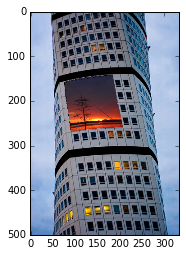

In [37]:
from matplotlib import tri

# 打开用来映射的图像
fromim = cv2.imread('sunset_tree.jpg')
fromim = cv2.cvtColor(fromim,cv2.COLOR_BGR2RGB)
x, y = meshgrid(range(5), range(6))

# 获得初始点
x = (fromim.shape[1]/4) * x.flatten()
y = (fromim.shape[0]/5) * y.flatten()

# 生成索引函数
fp = array(vstack((x, y)), 'int')
index_func = gen_find_index_list_func(fp.T)

# 载入对应图像
im = cv2.imread('turningtorso1.jpg')
im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)

# 载入对应点
tp = loadtxt('turningtorso1_points.txt', 'int')  # destination points
tp = array(vstack((tp[:, 0], tp[:, 1])), 'int')

# 生成三角形的索引形式
index_tri = triangulate_points(fromim,x,y,index_func)

# 生成结果图像
im_t = im.copy()
for t in index_tri:
    im_t = warpTriangle(fromim,im_t,fp[:,t].T,tp[:,t].T)
imshow(im_t) 

#### [绘制 Voronoi Diagram 图](http://www.learnopencv.com/delaunay-triangulation-and-voronoi-diagram-using-opencv-c-python/)

In [38]:
# 检验一个点在给定矩形中
def rect_contains(rect, point) :
    if point[0] < rect[0] :
        return False
    elif point[1] < rect[1] :
        return False
    elif point[0] > rect[2] :
        return False
    elif point[1] > rect[3] :
        return False
    return True

In [39]:
# 绘制一个点
def draw_point(img, p, color ) :
    cv2.circle( img, p, 2, color, cv2.cv.CV_FILLED, cv2.CV_AA, 0 )

In [40]:
# 绘制 delaunay 三角剖分
def draw_delaunay(img, subdiv, delaunay_color ) :
 
    triangleList = subdiv.getTriangleList();
    size = img.shape
    r = (0, 0, size[1], size[0])
 
    for t in triangleList :
         
        pt1 = (t[0], t[1])
        pt2 = (t[2], t[3])
        pt3 = (t[4], t[5])
         
        if rect_contains(r, pt1) and rect_contains(r, pt2) and rect_contains(r, pt3) :
         
            cv2.line(img, pt1, pt2, delaunay_color, 1, cv2.CV_AA, 0)
            cv2.line(img, pt2, pt3, delaunay_color, 1, cv2.CV_AA, 0)
            cv2.line(img, pt3, pt1, delaunay_color, 1, cv2.CV_AA, 0)

In [41]:
# 绘制 voronoi diagram 图
def draw_voronoi(img, subdiv) :
 
    ( facets, centers) = subdiv.getVoronoiFacetList([])
 
    for i in xrange(0,len(facets)) :
        ifacet_arr = []
        for f in facets[i] :
            ifacet_arr.append(f)
         
        ifacet = np.array(ifacet_arr, np.int)
        color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
 
        cv2.fillConvexPoly(img, ifacet, color, cv2.CV_AA, 0);
        ifacets = np.array([ifacet])
        cv2.polylines(img, ifacets, True, (0, 0, 0), 1, cv2.CV_AA, 0)
        cv2.circle(img, (centers[i][0], centers[i][1]), 3, (0, 0, 0), cv2.cv.CV_FILLED, cv2.CV_AA, 0)

In [42]:
# 定义绘图颜色
delaunay_color = (255,255,255)
points_color = (0, 0, 255)

# 读取图片
img = cv2.imread("image.jpg");

# 保持一个副本
img_orig = img.copy();

# 应用 Subdiv2D 的矩形
size = img.shape
rect = (0, 0, size[1], size[0])

# 创建一个 Subdiv2D 实例
subdiv = cv2.Subdiv2D(rect);

# 创建一个点序列
points = [];

# 从文本文档读取点
with open("points.txt") as file :
    for line in file :
        x, y = line.split()
        points.append((int(x), int(y)))

# 将点插入到 subdiv
for p in points :
    subdiv.insert(p)

# 绘制 delaunay 三角剖分
draw_delaunay( img, subdiv, delaunay_color );

# 绘制点
for p in points :
    draw_point(img, p, points_color)

# 为 Voronoi Diagram 图分配空间
img_voronoi = np.zeros(img.shape, dtype = img.dtype)

# 绘制 Voronoi diagram 图
draw_voronoi(img_voronoi,subdiv)

# S显示结果
imshow(img)
imshow(img_voronoi)

AttributeError: 'NoneType' object has no attribute 'copy'

#### [人脸识别示例](http://blog.csdn.net/GraceDD/article/details/51382952)